In [1]:
!pip install -q wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 248.6/248.6 kB 17.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 10.6 MB/s eta 0:00:00


In [3]:
import torch
import torchvision
import torch.nn as nn
from datetime import datetime
import numpy as np
import random

In [5]:
# Ensure deterministic behavior
torch.backends.cudnn.deterministic = True
random.seed(hash("setting random seeds") % 2**32 - 1)
np.random.seed(hash("improves reproducibility") % 2**32 - 1)
torch.manual_seed(hash("by removing stochasticity") % 2**32 - 1)
torch.cuda.manual_seed_all(hash("so runs are repeatable") % 2*32 - 1)

# Device configuration
device = (
    "cuda" if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

In [6]:
config = dict(
    epochs=5,
    classes=10,
    kernels=[32, 64],
    batch_size=64,
    learning_rate=0.001,
    momentum=0.9,
    dataset="FashionMNIST",
    architecture="CNN"
)

In [8]:
import wandb
wandb.login()

wandb.init(config=config, project="PyTorch-Learning-FashionMNIST", name="Experiment-2023-11-15")

wandb: Currently logged in as: venkata-ravuri. Use `wandb login --relogin` to force relogin


Subset RandomSampler used to split the dataset into train and validation subsets for validation of our model.

In [9]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.utils.data.sampler import SubsetRandomSampler # For validation dataset

transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.5,), std=(0.5,)) # Same as, mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)
        # Subtract 0.5 and then divide by 0.5 yielding an image with mean zero and values in range [-1, 1]
    ]
)

# Download tranining data from open datasets
train_data = datasets.FashionMNIST(
    root="./data",
    train=True,
    download=True,
    transform=transform,
)
# Download test data from open datasets.
test_data = datasets.FashionMNIST(
    root="./data",
    train=False,
    download=True,
    transform=transform
)

# Preparing valdiation dataset
indices = list(range(len(train_data)))
np.random.shuffle(indices)

# Get 20% of training dataset as validation dataset
split = int(np.floor(0.2 * len(train_data)))
print(f"Validation split: {split}")
train_sample = SubsetRandomSampler(indices[split:])
print(f"Train samples: {len(indices[split:])}")
validation_sample = SubsetRandomSampler(indices[:split])
print(f"Validation samples: {len(indices[:split])}")

100%|██████████| 26421880/26421880 [00:02<00:00, 12774013.01it/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 201793.86it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3745669.99it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 13718092.12it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw

Validation split: 12000
Train samples: 48000
Validation samples: 12000


In [11]:
# Create data loaders.
train_dataloader = DataLoader(train_data, sampler=train_sample, batch_size=config['batch_size'])
validation_dataloader = DataLoader(train_data, sampler=validation_sample, batch_size=config['batch_size'])
test_dataloader = DataLoader(test_data, batch_size=config['batch_size'], shuffle=True)

# Class labels
classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
        'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')

print(f'Training dataset has {len(train_data):,d} samples')
print(f'Test dataset has {len(test_data):,d} samples')

for X, y in validation_dataloader:
  print(f"Shape of X [N, C, H, W]: {X.shape}")
  print(f"Shape of y: {y.shape} {y.dtype}")
  break

# total = 0
# for batch_index, (inputs, labels) in enumerate(train_dataloader):
#   if batch_index % 100 == 99:
#     total += 100 * len(labels)
#     print(f"{batch_index}; {len(labels)} - {total}")

Training dataset has 60,000 samples
Test dataset has 10,000 samples
Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


 ### Visualizing a grid of images

 torchvision.utils.make_grid() function creates a tensor that represents multiple images in a grid.

Images shape: torch.Size([64, 1, 28, 28])
Image grid shape: torch.Size([3, 242, 242])
0:Coat 1:Coat 2:Pullover 3:Bag 4:Pullover 5:Trouser 6:Coat 7:Ankle Boot 


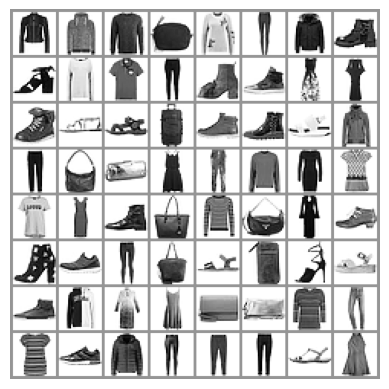

In [12]:
import matplotlib.pyplot as plt
import numpy as np

# Helper function for inline image display
def matplotlib_imshow(img, one_channel=False):
  plt.axis('off')
  if one_channel:
    # mean of an image across the channels Red, Green, and, Blue. dim=0, does torch.squeeze(), resulting in the output tensor having 1 (or len(dim)) fewer dimension(s).
    img = img.mean(dim=0)
  img = img / 2 + 0.5 #unnormalize - Reverse normalization operation.
  npimg = img.numpy()
  if one_channel:
    plt.imshow(npimg, cmap="Greys")
  else:
    # (1,2,0) in transpose means the permutation to the indices. Turns a tensor of shape: [channels, height, width] into: [height, width, channels]
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

dataiter = iter(train_dataloader)
images, labels = next(dataiter)
print(f'Images shape: {images.shape}')

# Create a grid from the images, by default number of images displayed in each row of the grid is 8 with padding of 2.
img_grid = torchvision.utils.make_grid(images)
print(f'Image grid shape: {img_grid.shape}') # Shape of image grid: 3 X (8*28+9*2) X (8*28+9*2) = 3 x 242 x 242
matplotlib_imshow(img_grid, one_channel=True)
print(''.join(f'{j}:{classes[labels[j]]} ' for j in range(8)))

Refer to [Convolution Notes](https://github.com/venkataravuri/ai-ml/edit/master/docs/nn/nn-deeplearning.md#convolution-operation)

Neural Net has following layers:

- Layer 1 - A sequential layer,
  - Convolution layer that has kernel size of 3 * 3, padding = 1 (zero padding), stride of 1
  - [Batch Normalization](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html) layer.
  - Activation function: ReLU
  - Max pooling layer with kernel size of 2 * 2 and stride 2


In [13]:
import torch.nn.functional as F

print(f"Usining '{device}' device")

# Define model
class GarmentClassifier(nn.Module):
  def __init__(self):
    super(GarmentClassifier, self).__init__()
    # Input shape [N C H W] - batch size x input channels x height x width
    self.layer1 = nn.Sequential(
      # Convolution operation, 1 input image channel, 32 output channels, 3x3 square convolution kernel
      nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(3,3), stride=(1,1), padding=(1,1)), # Output feature map shape ? x ? x ?
      nn.BatchNorm2d(32),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2, stride=2)
    )
    self.layer2 = nn.Sequential(
        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3), # Output shape after applying max pooling: ? x ? x ?
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )
    self.fc1 = nn.Linear(in_features=64 * 6 * 6, out_features=600)
    self.drop = nn.Dropout2d(0.25)
    self.fc2 = nn.Linear(in_features=600, out_features=120)
    self.fc3 = nn.Linear(in_features=120, out_features=10)


  def forward(self, x):
    x = self.layer1(x)
    x = self.layer2(x)
    x = x.view(-1, 64 * 6 * 6) # Converts into [N, ???]
    x = self.fc1(x)
    x = self.drop(x)
    x = self.fc2(x)
    x = self.fc3(x)
    return x

Usining 'cuda' device


In [14]:
model = GarmentClassifier().to(device)
print(model)

GarmentClassifier(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=2304, out_features=600, bias=True)
  (drop): Dropout2d(p=0.25, inplace=False)
  (fc2): Linear(in_features=600, out_features=120, bias=True)
  (fc3): Linear(in_features=120, out_features=10, bias=True)
)


### Loss Function
Using Cross-entropy loss.

In [15]:
loss_fn = torch.nn.CrossEntropyLoss()

### Optimizer

For this example, using simple `stochastic gradient descent`

In [17]:
optimizer = torch.optim.SGD(model.parameters(), lr=config['learning_rate'], momentum=config['momentum'])

In [18]:
# Tell wandb to watch what the model get up to: gradients, weights, and more!
# log_freq: log gradients and parameters every N batches
# log: Optional[Literal['gradients', 'parameters', 'all']]
wandb.watch(model, criterion=loss_fn, log='all', log_freq=100)

[]

### The Training Loop

- Gets a batch of training data from the DataLoader
- Zeros the optimzer's gradients
- Performs an inference - that is, get predictions from the model for an input batch
- Calculates the loss for that set of predictions vs. the labels on the dataset
- Tells optimizer to perform one learning step - that is, adjust the model's learning weights based
on the observed gradients for this batch, according the optimization algorithm we chose
- It report on the loss for every 100 batches.
- Finally, it reports the average per-batch loss for the last 100 batches, for comparision with the validation run

In [19]:
def train_one_epoch(epoch_index):
  running_loss = 0
  last_loss = 0

  correct, total = 0, 0

  for batch_index, (inputs, labels) in enumerate(train_dataloader):


    inputs = inputs.to(device)
    labels = labels.to(device)

    # Zero gradients for every batch.
    optimizer.zero_grad()


    # Make predictions for this batch
    outputs = model(inputs)

    # Compute loss and its gradients
    loss = loss_fn(outputs, labels)
    loss.backward()

    # Adjust learning weights
    optimizer.step()

    running_loss += loss.item()
    predictions = torch.max(outputs, 1)[1].to(device)
    correct = (predictions == labels).sum()
    total += len(labels)

    if batch_index % 100 == 99:
      last_loss = running_loss / 100 # loss per batch
      accuracy = correct * 100 / total
      print(f'Batch: {batch_index+1}; avg train loss across past 100 batches: {last_loss}; accuracy: {accuracy:%}')
      wandb.log({"epoch": epoch_index, "train-loss": last_loss, "accuracy": accuracy})
      running_loss, correct, total = 0, 0, 0

  return last_loss


In [20]:
timestamp = datetime.now().strftime('%Y%Mm%d_%H%M%S')
epoch_number = 0

best_vloss = np.Inf # Unsing high value to make sure update weight for first time.

for epoch in range(config['epochs']):
  print(f"\nEPOCH: {epoch_number+1}\n{'-'*65}")

  # Make sure gradient tracking is on, and do a pass over the data
  model.train(True)
  avg_loss = train_one_epoch(epoch_number)

  running_vloss = 0.0

  # Set the model to evaluation mode, disabling dropout and
  # using population statistics for batch normalization.
  model.eval()

  correct, total = 0, 0

  with torch.no_grad():
    for vbatch_index, (vinputs, vlabels) in enumerate(validation_dataloader):
      vinputs = vinputs.to(device)
      vlabels = vlabels.to(device)
      voutputs = model(vinputs)
      vloss = loss_fn(voutputs, vlabels)
      running_vloss += vloss

      predictions = torch.max(voutputs, 1)[1].to(device)
      correct += (predictions == vlabels).sum()
      total += len(labels)

  avg_vloss = running_vloss / (vbatch_index + 1)
  print(f"{correct}; {total}")
  accuracy = correct / total
  print(f'Training loss: {avg_loss} and Validation loss: {avg_vloss}; Accuracy:{accuracy:%}')
  wandb.log({"test_accuracy": accuracy})

  # Track best performance, and save the model's state
  if avg_vloss < best_vloss:
    best_vloss = avg_vloss
    torch.save(model.state_dict(), f'model_{timestamp}_{epoch_number}')

  epoch_number +=1


EPOCH: 1
-----------------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Batch: 100; avg train loss across past 100 batches: 1.2846813637018204; accuracy: 65.625000%
Batch: 200; avg train loss across past 100 batches: 0.6616457813978195; accuracy: 71.875000%
Batch: 300; avg train loss across past 100 batches: 0.5637909942865371; accuracy: 82.812500%
Batch: 400; avg train loss across past 100 batches: 0.5114979964494705; accuracy: 82.812500%
Batch: 500; avg train loss across past 100 batches: 0.47561430305242536; accuracy: 85.937500%
Batch: 600; avg train loss across past 100 batches: 0.4484014257788658; accuracy: 84.375000%
Batch: 700; avg train loss across past 100 batches: 0.41858225122094156; accuracy: 89.062500%
10252; 12032
Training loss: 0.41858225122094156 and Validation loss: 0.4088948369026184; Accuracy:85.206115%
EPOCH: 2
-----------------------------------------------------------------
Batch: 100; avg train loss across past 100 batches: 0.39971558153629305; accuracy: 92.187500%
Batch: 200; avg train loss across past 100 batches: 0.373532990366220

In [63]:
print(list(model.children()))

[Sequential(
  (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
), Sequential(
  (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
), Linear(in_features=2304, out_features=600, bias=True), Dropout2d(p=0.25, inplace=False), Linear(in_features=600, out_features=120, bias=True), Linear(in_features=120, out_features=10, bias=True)]


Feature map shape: torch.Size([32, 28, 28])
Modified feature map shape: torch.Size([32, 1, 28, 28])


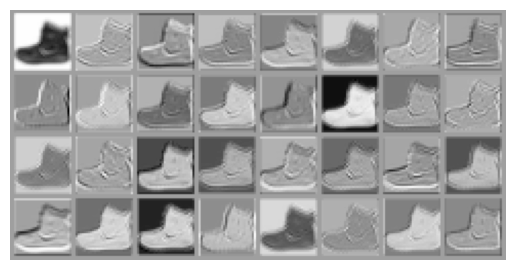

In [75]:
X, y = train_data[0][0], train_data[0][1]
model.eval()
with torch.no_grad():
  X = X.to(device)
  # Gets first layer's Conv2D weights
  layer1_conv2d_feature_maps = model.layer1[0](X)

def display_feature_maps(feature_maps):
  feature_maps = feature_maps.to('cpu')
  print(f'Feature map shape: {feature_maps.shape}')
  # add a new axis with torch.unsqueeze() (first argument being the index of the new axis)
  feature_maps = feature_maps.unsqueeze(1)
  print(f'Modified feature map shape: {feature_maps.shape}')
  img_grid = torchvision.utils.make_grid(feature_maps)
  matplotlib_imshow(img_grid, one_channel=True)

display_feature_maps(layer1_conv2d_feature_maps)

Filter shape: torch.Size([32, 1, 3, 3])


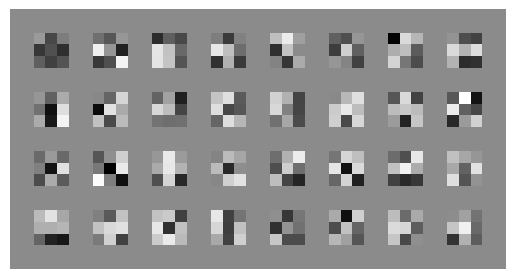

In [77]:
from itertools import filterfalse
# get the kernels from the first layer
# as per the name of the layer
filters = model.layer1[0].weight.data.clone()
filters = filters.to('cpu')
print(f'Filter shape: {filters.shape}')
img_grid = torchvision.utils.make_grid(filters)
matplotlib_imshow(img_grid, one_channel=True)

In [79]:
model.eval()
X, y = test_data[0][0], test_data[0][1]
with torch.no_grad():
  X = X.to(device)
  X = X.unsqueeze(0)
  pred = model(X)
  predicted, actual = classes[pred[0].argmax(0)], classes[y]
  print(f'Predicted: "{predicted}", Actual: "{actual}"')

Predicted: "Ankle Boot", Actual: "Ankle Boot"


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)
